In [ ]:
from torchvision import datasets, models
from torchvision.transforms import v2

import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import torchvision
import numpy as np

import torch

# if you have CUDA set it to the active device like this
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device

'cuda'

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
main_directory = r'/content/drive/MyDrive/Eyes_classification'
train_folder = r'/content/drive/MyDrive/Eyes_classification/EyesDataset_labled2/train'
test_folder = r'/content/drive/MyDrive/Eyes_classification/EyesDataset_labled2/test'
#train_folder = os.path.join(main_directory, 'for YOLO classification','train')
#test_folder = os.path.join(main_directory,'for YOLO classification','test')

data_transform_train = v2.Compose([
        #v2.Resize((227,227)), #for vgg only
        #v2.Resize((128,128)), #for vgg only
        v2.RandomHorizontalFlip(p=0.5),
        #v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        #v2.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
        #v2.RandomAdjustSharpness(sharpness_factor=0, p=0.3),
        #v2.ColorJitter(brightness=0.5, contrast=1),
        v2.ToTensor(),
        #v2.Normalize((0.5, ), (0.5, )),
        #v2.Grayscale(),
    ])

data_transform_test = v2.Compose([
        #v2.Resize((227,227)),#for vgg only
        #v2.Resize((128,128)), #for vgg only
        v2.ToTensor(),
        #v2.Normalize((0.5, ), (0.5, )),
        #v2.Grayscale(),
    ])
#BATCH_SIZE = 128 #for vgg
#BATCH_SIZE = 1024 #for resnet
#BATCH_SIZE = 1500 #for mobilenet
BATCH_SIZE = 16 #for small dataset
eyes_dataset_train = datasets.ImageFolder(root=train_folder, transform=data_transform_train)
eyes_dataset_test = datasets.ImageFolder(root=test_folder, transform=data_transform_test)

def collate_fn(batch):
    images, labels = [], []
    for image, label in batch:
        image = torch.tensor(image / 255)
        image = image.permute((0, 1, 2)).float()
        images.append(image)

        label = torch.tensor([label]).float()
        labels.append(label)

    images = torch.stack(images).to(device)
    labels = torch.stack(labels).to(device)
    return images, labels


train_loader = torch.utils.data.DataLoader(eyes_dataset_train,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             collate_fn = collate_fn)
test_loader = torch.utils.data.DataLoader(eyes_dataset_test,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             collate_fn = collate_fn)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
def visualize_batch(batch, classes, dataset_type):
    # initialize a figure
    fig = plt.figure("{} batch".format(dataset_type),
        figsize=(8, 8))
    # loop over the batch size
    for i in range(0, BATCH_SIZE):
        # create a subplot
        ax = plt.subplot(2, 4, i + 1)
        #current_image = test_dataset[index][0]
        print(np.shape(batch[0][i]))
        image = batch[0][i].permute((0, 2, 1)).float().cpu()
        #image = batch[0][i].clone().detach()
        print(np.shape(image))
        #input_image = torch.tensor(image / 255)
        idx = int(batch[1][i].cpu().numpy())
        print('idx', idx)
        label = classes[idx]
        plt.imshow(image, cmap='gray')
        plt.title(label)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
# grab a batch from both training and validation dataloader
#trainBatch = next(iter(train_loader))
#visualize_batch(trainBatch, eyes_dataset_train.classes, "train")

In [ ]:
#testBatch = next(iter(test_loader))
#visualize_batch(testBatch, eyes_dataset_test.classes, "test")

# Train

In [ ]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00


In [ ]:
import torch.nn as nn
from IPython.display import clear_output
from torch import nn
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import wandb

def epoch_train(loader, clf, criterion, opt):

    sigmoid = torch.nn.Sigmoid()
    avg_loss = 0

    num_correct = 0
    num_samples = 0
    clf.train(True)

    for batch, (X, y) in enumerate(loader):


        X, y = X.to(device), y.to(device)
        # print(np.shape(X)) --- torch.Size([16, 3, 128, 128])
        opt.zero_grad()

        output = clf(X)
        pred = sigmoid(output) #range between 0 and 1
        loss = criterion(pred,y)
        # Backpropagation
        loss.backward()
        opt.step()


        avg_loss += loss.item()
        #print('pred: ', pred) #tensor([[0.4870],[0.5006],[0.4826],
        predictions = (pred > 0.6).long()
        #print('predictions:', predictions) # tensor([[0],[0],[0],[0],
        num_correct += (predictions == y).sum()
        num_samples += predictions.size(0)

    return avg_loss / len(loader.dataset), float(num_correct)/float(num_samples)


def epoch_test(loader, clf, criterion):
    sigmoid = torch.nn.Sigmoid()

    clf.eval()
    avg_loss = 0
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for batch,(X, y) in enumerate(loader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            output = clf(X)
            pred = sigmoid(output) #range between 0 and 1
            loss = criterion(pred,y)

            avg_loss += loss.item()
            predictions = (pred > 0.6).long()
            #print(predictions)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    return avg_loss / len(loader.dataset), float(num_correct)/float(num_samples)



def train(train_loader, test_loader, clf, criterion, opt, weight_path, model_name,  n_epochs = 10):
    best_test_acc = 0
    val_losses = []
    train_losses = []
    train_acces = []
    test_acces = []

    for epoch in tqdm(range(n_epochs)):

        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)
        train_losses.append(train_loss)
        val_losses.append(test_loss)
        train_acces.append(train_acc)
        test_acces.append(test_acc)
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(clf.state_dict(), os.path.join(weight_path, '{}_best_weights.pth'.format(model_name)))

        #wandb.log({"test_accuracy": test_acc, "test_loss": test_loss})
        wandb.log({"train_loss": float(train_loss), "test_loss": float(test_loss), "train_acc": float(train_acc), "test_acc": float(test_acc)}, step=epoch)
        time.sleep(2)
        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.3f}; ' +
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.3f}')
    wandb.finish()
    print('best test accuracy =', best_test_acc)
    return val_losses, train_losses, train_acces, test_acces

In [ ]:
def custom_mobilenet_v3_small():
    model = torchvision.models.mobilenet_v3_small(pretrained = True, progress=True)
    model.classifier = torch.nn.Sequential(
        torch.nn.Linear(in_features=576, out_features=128, bias=True),
        torch.nn.Hardswish(),
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=128, out_features=1, bias=True)
    )
    return model

In [ ]:
def custom_mobilenet_v3_large():
    model = torchvision.models.mobilenet_v3_large(pretrained = True, progress=True)
    model.classifier = torch.nn.Sequential(
        torch.nn.Linear(in_features=960, out_features=128, bias=True),
        torch.nn.Hardswish(),
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=128, out_features=1, bias=True)
    )
    return model

In [ ]:
def custom_resnet101():
    model = torchvision.models.resnet101(pretrained = True, progress=True)
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(in_features=2048, out_features=1000, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.2, inplace=False),
        torch.nn.Linear(in_features=1000, out_features=1, bias=True)
    )
    return model

In [ ]:
def custom_resnet18():
    model = torchvision.models.resnet18(pretrained = True, progress=True)
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(in_features=512, out_features=256, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.2, inplace=False),
        torch.nn.Linear(in_features=256, out_features=1, bias=True)
    )
    return model

In [ ]:
def custom_resnet50():
    model = torchvision.models.resnet50(pretrained = True, progress=True)
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(in_features=2048, out_features=1000, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.2, inplace=False),
        torch.nn.Linear(in_features=1000, out_features=1, bias=True)
    )
    return model

In [ ]:
def custom_vgg16():
    model = torchvision.models.vgg16(pretrained = True, progress=True)
    model.classifier = torch.nn.Sequential(
        torch.nn.Linear(in_features=25088, out_features=4096, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5, inplace=False),
        torch.nn.Linear(in_features=4096, out_features=274, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5, inplace=False),
        torch.nn.Linear(in_features=274, out_features=1, bias=True),
    )
    return model

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

N_EPOCHS = 30
#model = models.vgg16(pretrained= True)
model = custom_resnet50()
#model = torchvision.models.resnet101(pretrained= True)
#model = torchvision.models.mobilenet_v3_large(pretrained = True, progress=True)
model.to(device)
model_name = 'custom_resnet50'
opt = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()
#criterion = torch.nn.BCEWithLogitsLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.3MB/s]


In [ ]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Eyes_open_close_classification",
)

weight_path = os.path.join(main_directory, 'weights')
val_losses, train_losses, train_acces, test_acces = train(train_loader, test_loader, model, criterion, opt, weight_path, model_name, n_epochs=N_EPOCHS)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anna-ilyushina20. Use `wandb login --relogin` to force relogin


  0%|          | 0/30 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_32732\3067089176.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image / 255)
  3%|▎         | 1/30 [00:06<03:03,  6.33s/it]

[Epoch 1] train loss: 0.026; train acc: 0.801; test loss: 0.090; test acc: 0.544


  7%|▋         | 2/30 [00:12<02:48,  6.01s/it]

[Epoch 2] train loss: 0.018; train acc: 0.886; test loss: 0.154; test acc: 0.544


 10%|█         | 3/30 [00:17<02:40,  5.95s/it]

[Epoch 3] train loss: 0.015; train acc: 0.903; test loss: 0.097; test acc: 0.544


 13%|█▎        | 4/30 [00:27<03:15,  7.52s/it]

[Epoch 4] train loss: 0.013; train acc: 0.916; test loss: 0.158; test acc: 0.622


 17%|█▋        | 5/30 [00:38<03:31,  8.46s/it]

[Epoch 5] train loss: 0.011; train acc: 0.929; test loss: 0.026; test acc: 0.825


 20%|██        | 6/30 [00:47<03:32,  8.86s/it]

[Epoch 6] train loss: 0.012; train acc: 0.927; test loss: 0.012; test acc: 0.922


 23%|██▎       | 7/30 [00:57<03:28,  9.05s/it]

[Epoch 7] train loss: 0.014; train acc: 0.929; test loss: 0.015; test acc: 0.922


 27%|██▋       | 8/30 [01:06<03:21,  9.17s/it]

[Epoch 8] train loss: 0.011; train acc: 0.934; test loss: 0.012; test acc: 0.914


 30%|███       | 9/30 [01:16<03:14,  9.26s/it]

[Epoch 9] train loss: 0.009; train acc: 0.940; test loss: 0.012; test acc: 0.924


 33%|███▎      | 10/30 [01:25<03:06,  9.33s/it]

[Epoch 10] train loss: 0.009; train acc: 0.943; test loss: 0.013; test acc: 0.922


 37%|███▋      | 11/30 [01:35<02:58,  9.39s/it]

[Epoch 11] train loss: 0.009; train acc: 0.946; test loss: 0.010; test acc: 0.940


 40%|████      | 12/30 [01:44<02:49,  9.44s/it]

[Epoch 12] train loss: 0.008; train acc: 0.953; test loss: 0.017; test acc: 0.911


 43%|████▎     | 13/30 [01:53<02:40,  9.42s/it]

[Epoch 13] train loss: 0.007; train acc: 0.958; test loss: 0.017; test acc: 0.888


 47%|████▋     | 14/30 [02:03<02:30,  9.41s/it]

[Epoch 14] train loss: 0.007; train acc: 0.956; test loss: 0.011; test acc: 0.931


 50%|█████     | 15/30 [02:12<02:22,  9.48s/it]

[Epoch 15] train loss: 0.008; train acc: 0.955; test loss: 0.012; test acc: 0.926


 53%|█████▎    | 16/30 [02:22<02:12,  9.48s/it]

[Epoch 16] train loss: 0.007; train acc: 0.955; test loss: 0.010; test acc: 0.945


 57%|█████▋    | 17/30 [02:31<02:02,  9.46s/it]

[Epoch 17] train loss: 0.007; train acc: 0.957; test loss: 0.017; test acc: 0.895


 60%|██████    | 18/30 [02:41<01:53,  9.44s/it]

[Epoch 18] train loss: 0.007; train acc: 0.958; test loss: 0.013; test acc: 0.921


 63%|██████▎   | 19/30 [02:50<01:43,  9.43s/it]

[Epoch 19] train loss: 0.006; train acc: 0.961; test loss: 0.015; test acc: 0.911


 67%|██████▋   | 20/30 [03:00<01:34,  9.46s/it]

[Epoch 20] train loss: 0.006; train acc: 0.959; test loss: 0.011; test acc: 0.929


 70%|███████   | 21/30 [03:09<01:25,  9.45s/it]

[Epoch 21] train loss: 0.006; train acc: 0.966; test loss: 0.028; test acc: 0.805


 73%|███████▎  | 22/30 [03:19<01:15,  9.50s/it]

[Epoch 22] train loss: 0.006; train acc: 0.962; test loss: 0.012; test acc: 0.922


 77%|███████▋  | 23/30 [03:28<01:06,  9.51s/it]

[Epoch 23] train loss: 0.005; train acc: 0.975; test loss: 0.014; test acc: 0.927


 80%|████████  | 24/30 [03:38<00:56,  9.49s/it]

[Epoch 24] train loss: 0.005; train acc: 0.968; test loss: 0.014; test acc: 0.901


 83%|████████▎ | 25/30 [03:47<00:47,  9.47s/it]

[Epoch 25] train loss: 0.005; train acc: 0.972; test loss: 0.012; test acc: 0.914


 87%|████████▋ | 26/30 [03:57<00:37,  9.43s/it]

[Epoch 26] train loss: 0.005; train acc: 0.973; test loss: 0.017; test acc: 0.916


 90%|█████████ | 27/30 [04:06<00:28,  9.43s/it]

[Epoch 27] train loss: 0.005; train acc: 0.971; test loss: 0.020; test acc: 0.873


 93%|█████████▎| 28/30 [04:12<00:16,  8.43s/it]

[Epoch 28] train loss: 0.005; train acc: 0.971; test loss: 0.017; test acc: 0.900


 97%|█████████▋| 29/30 [04:18<00:07,  7.67s/it]

[Epoch 29] train loss: 0.004; train acc: 0.975; test loss: 0.012; test acc: 0.930


100%|██████████| 30/30 [04:28<00:00,  8.94s/it]

: 

# VALIDATION

In [ ]:
# загрузить наилучшие веса
best_model_weights = r'/content/drive/MyDrive/Eyes_classification/resnet50_best_weights.pth'
model.load_state_dict(torch.load(best_model_weights, weights_only=True))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
y_predict = []
y_true = []
sigmoid = torch.nn.Sigmoid()
count = 0
for batch,(X, y) in enumerate(test_loader):
      model.eval()
      X, y = X.to(device), y.to(device)
      output = model(X)
      pred = sigmoid(output)
      #print(pred)
      predictions = (pred > 0.6).long()
      #print(predictions)
      list_predictions = predictions[:, 0].tolist()
      list_y = y[:, 0].tolist()
      y_predict += list_predictions
      y_true += list_y



<ipython-input-5-2b90ff46fbcc>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image / 255)


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_true, y_predict, pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print(EER)

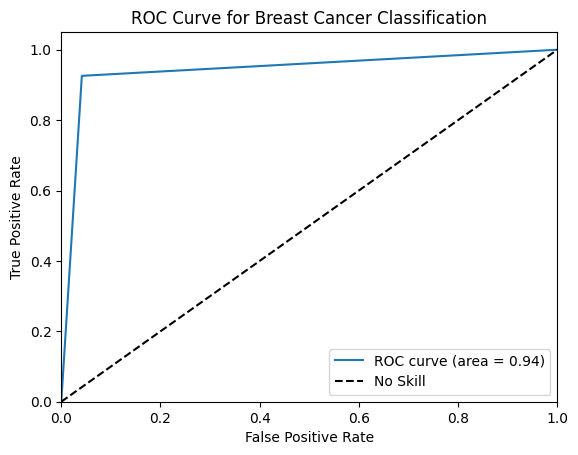

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_predict)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Breast Cancer Classification')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support
print(model_name)
conf_matrix = confusion_matrix(y_true, y_predict)
print("Confusion Matrix:")
print(conf_matrix)

print('\nClassification Report : ')
print(classification_report(y_true, y_predict))

print('Precision                                   : %.3f'%precision_score(y_true, y_predict))
print('Recall                                      : %.3f'%recall_score(y_true, y_predict))
print('F1-Score                                    : %.3f'%f1_score(y_true, y_predict))

custom_mobilenet_v3_large_3
Confusion Matrix:
[[416  18]
 [ 26 338]]

Classification Report : 
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       434
         1.0       0.95      0.93      0.94       364

    accuracy                           0.94       798
   macro avg       0.95      0.94      0.94       798
weighted avg       0.94      0.94      0.94       798

Precision                                   : 0.949
Recall                                      : 0.929
F1-Score                                    : 0.939


# Визуализация предсказаний

<ipython-input-5-2b90ff46fbcc>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image / 255)


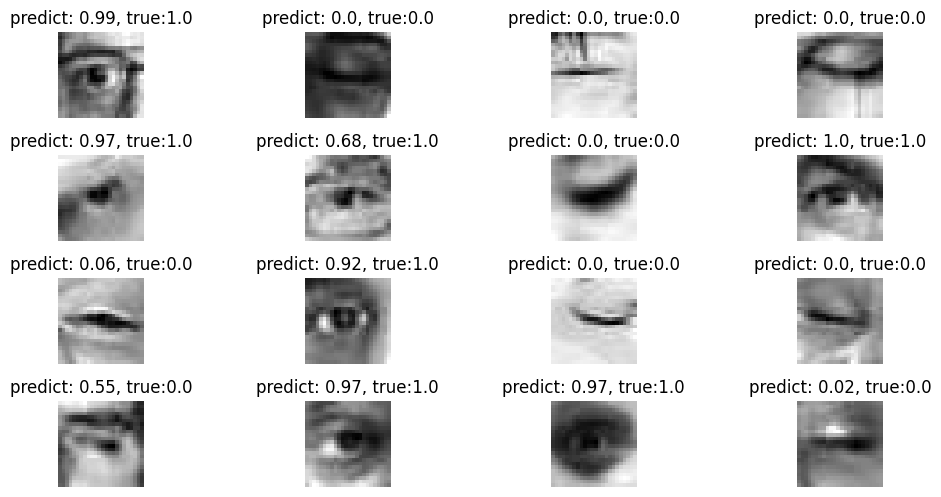

In [ ]:
#prediction from dataloader

testBatch = next(iter(test_loader))
sigmoid = torch.nn.Sigmoid()
fig = plt.figure("{} batch".format('test'),
    figsize=(10, 10))
# loop over the batch size
for i in range(0, BATCH_SIZE):
    # create a subplot
    ax = plt.subplot(8, 4, i + 1)
    true_idx = testBatch[1][i]
    print()

    model.eval()
    input = torch.unsqueeze(testBatch[0][i].to(device), 0)

    output = model(input)
    output = round(sigmoid(output).item(),2)
    image = testBatch[0][i].cpu().numpy()
    plt.imshow(image[0], cmap='gray')
    plt.title('predict: {}, true:{}'.format(output, true_idx.item()))
    plt.axis("off")
plt.tight_layout()
plt.show()

torch.Size([3, 24, 24])
tensor([[[0.5059, 0.4824, 0.4706,  ..., 0.4863, 0.4549, 0.4353],
         [0.4980, 0.4745, 0.4627,  ..., 0.5176, 0.4863, 0.4667],
         [0.4902, 0.4667, 0.4510,  ..., 0.5490, 0.5176, 0.4980],
         ...,
         [0.5608, 0.5176, 0.4863,  ..., 0.6196, 0.6039, 0.5922],
         [0.5765, 0.5255, 0.4784,  ..., 0.6157, 0.6000, 0.5882],
         [0.5843, 0.5255, 0.4745,  ..., 0.6039, 0.5882, 0.5725]],

        [[0.5059, 0.4824, 0.4706,  ..., 0.4863, 0.4549, 0.4353],
         [0.4980, 0.4745, 0.4627,  ..., 0.5176, 0.4863, 0.4667],
         [0.4902, 0.4667, 0.4510,  ..., 0.5490, 0.5176, 0.4980],
         ...,
         [0.5608, 0.5176, 0.4863,  ..., 0.6196, 0.6039, 0.5922],
         [0.5765, 0.5255, 0.4784,  ..., 0.6157, 0.6000, 0.5882],
         [0.5843, 0.5255, 0.4745,  ..., 0.6039, 0.5882, 0.5725]],

        [[0.5059, 0.4824, 0.4706,  ..., 0.4863, 0.4549, 0.4353],
         [0.4980, 0.4745, 0.4627,  ..., 0.5176, 0.4863, 0.4667],
         [0.4902, 0.4667, 0.4510, 

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


torch.Size([3, 24, 24])
tensor([[[0.6118, 0.6000, 0.5843,  ..., 0.4392, 0.4275, 0.4157],
         [0.5882, 0.5804, 0.5686,  ..., 0.4431, 0.4275, 0.4118],
         [0.5647, 0.5608, 0.5490,  ..., 0.4588, 0.4353, 0.4157],
         ...,
         [0.4196, 0.4275, 0.4353,  ..., 0.4980, 0.4941, 0.4902],
         [0.4118, 0.4196, 0.4314,  ..., 0.5059, 0.4980, 0.4941],
         [0.4078, 0.4157, 0.4314,  ..., 0.5059, 0.4980, 0.4941]],

        [[0.6118, 0.6000, 0.5843,  ..., 0.4392, 0.4275, 0.4157],
         [0.5882, 0.5804, 0.5686,  ..., 0.4431, 0.4275, 0.4118],
         [0.5647, 0.5608, 0.5490,  ..., 0.4588, 0.4353, 0.4157],
         ...,
         [0.4196, 0.4275, 0.4353,  ..., 0.4980, 0.4941, 0.4902],
         [0.4118, 0.4196, 0.4314,  ..., 0.5059, 0.4980, 0.4941],
         [0.4078, 0.4157, 0.4314,  ..., 0.5059, 0.4980, 0.4941]],

        [[0.6118, 0.6000, 0.5843,  ..., 0.4392, 0.4275, 0.4157],
         [0.5882, 0.5804, 0.5686,  ..., 0.4431, 0.4275, 0.4118],
         [0.5647, 0.5608, 0.5490, 

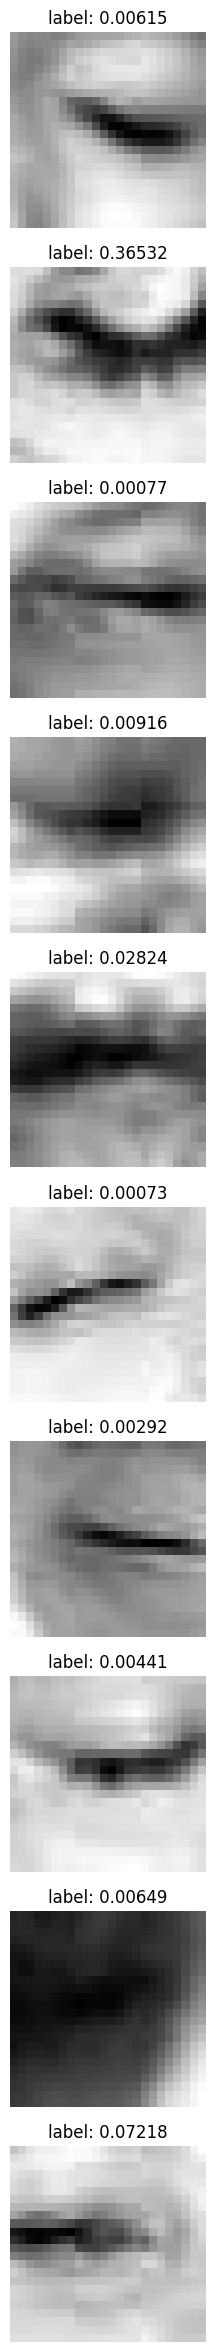

In [ ]:
#prediction from dataset
sigmoid = torch.nn.Sigmoid()
plt.figure(figsize=(5, 30))
for index in range(10):
    current_image = eyes_dataset_train[index][0]
    print(np.shape(current_image))
    print(current_image)
    transform = v2.Compose([v2.ToTensor()])
    tensor = transform(current_image)
    input = torch.tensor([np.array(tensor) / 255])
    input_image = input.float().to(device)
    output = round(sigmoid(model(input_image)).item(), 5)
    plt.subplot(10, 1, index+1)
    plt.title(f"label: {output}")
    plt.axis("off")
    plt.imshow(current_image[0], cmap='gray')
plt.show()

In [ ]:
image_pth = '/content/drive/MyDrive/Eyes_classification/EyesDataset_labled2/test/0/000015.jpg'
im = Image.open(image_pth) #24x2
transform = v2.Compose([v2.ToTensor()])
tensor = transform(im)
print(np.shape(tensor))
#print(tensor)
rgb_batch = np.repeat(tensor[..., np.newaxis], 3, 0)
print(np.shape(rgb_batch))
rgb_batch = torch.squeeze(rgb_batch, 3)
print(np.shape(rgb_batch))
input = torch.tensor([np.array(rgb_batch) / 255])
print(np.shape(input))
input_image = input.float().to(device)
output = round(sigmoid(model(input_image)).item(), 5)

torch.Size([1, 24, 24])
torch.Size([3, 24, 24, 1])
torch.Size([3, 24, 24])
torch.Size([1, 3, 24, 24])


In [ ]:
output

1e-05

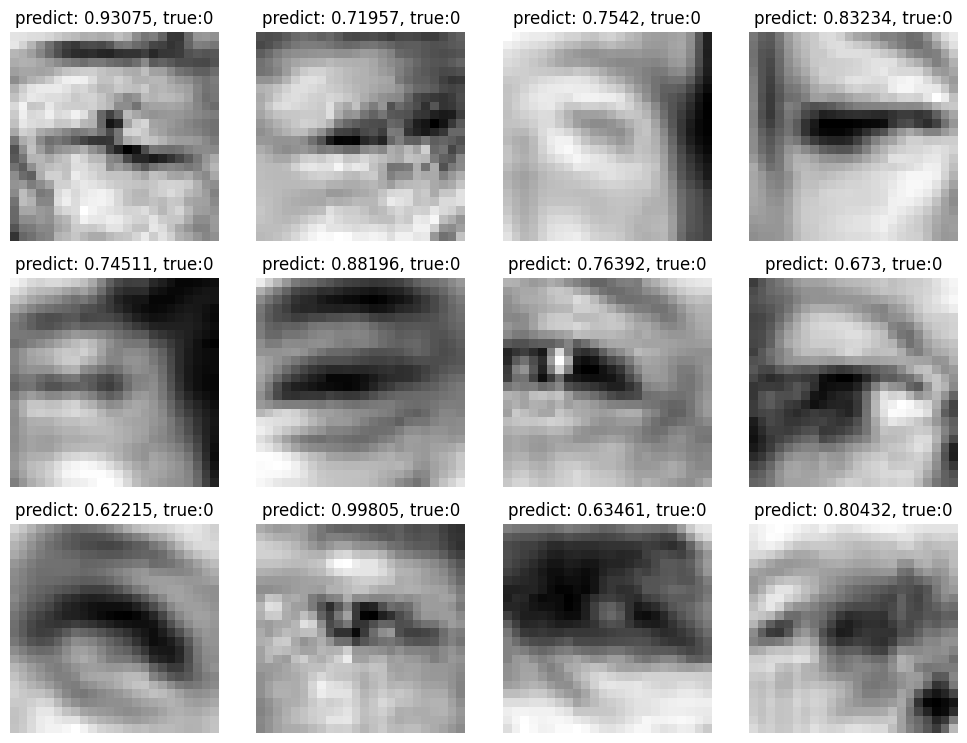

In [ ]:
from PIL import Image
k=0
sigmoid = torch.nn.Sigmoid()
model.eval()

plt.figure(figsize=(10, 10))
test_folder = '/content/drive/MyDrive/Eyes_classification/EyesDataset_labled2/test'
for i in ['0', '1']:
  if i=='0':
    #FP: true =0 , predict=1
    #FN: true =1, predict=0
    for image_name in os.listdir(os.path.join(test_folder,i)):

      im = Image.open(os.path.join(test_folder, i, image_name))
      transform = v2.Compose([v2.ToTensor()])
      tensor = transform(im)
      rgb_batch = np.repeat(tensor[..., np.newaxis], 3, 0)
      rgb_batch = torch.squeeze(rgb_batch, 3)
      input = torch.tensor([np.array(rgb_batch) / 255])
      input_image = input.float().to(device)
      output = round(sigmoid(model(input_image)).item(), 5)

      if output>0.6 and int(i)==0:
        ax = plt.subplot(4, 4, k + 1)
        plt.imshow(im, cmap='gray')
        plt.title('predict: {}, true:{}'.format(output, int(i)))
        plt.axis("off")
        k +=1
        if k==16:
          break
      if output<0.6 and int(i)==1:
        ax = plt.subplot(4, 4, k + 1)
        plt.imshow(im, cmap='gray')
        plt.title('predict: {}, true:{}'.format(output, int(i)))
        plt.axis("off")
        k +=1
        if k==16:
          break
plt.tight_layout()
plt.show()

In [ ]:
    plt.imshow(image[0], cmap='gray')
    plt.title('predict: {}, true:{}'.format(output, true_idx.item()))
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
import torch
from torchvision.transforms import v2
from PIL import Image

class OpenEyesClassificator():
  def __init__(self):


    self.sigmoid = torch.nn.Sigmoid()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_model_weights = 'resnet50_best_weights.pth'
    model.load_state_dict(torch.load(best_model_weights, weights_only=True))
    model.to(device)
    self.model = model

    def custom_resnet50(self):

        model = torchvision.models.resnet50(pretrained = True, progress=True)
        model.fc = torch.nn.Sequential(
        torch.nn.Linear(in_features=2048, out_features=1000, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.2, inplace=False),
        torch.nn.Linear(in_features=1000, out_features=1, bias=True)
    )
    return model

    model = custom_resnet50()

    def predict(self, inpIm):

      self.model.eval()
      #загрузить изображение
      im = Image.open(inpIm)
      transform = v2.Compose([v2.ToTensor()])
      tensor = transform(im)
      #продублировать чб изображение 3 раза для имитации RGB
      rgb_batch = np.repeat(tensor[..., np.newaxis], 3, 0)
      rgb_batch = torch.squeeze(rgb_batch, 3)
      #нормализовать
      input = torch.tensor([np.array(rgb_batch) / 255])

      input_image = input.float().to(device)
      is_open_score = round(self.sigmoid(model(input_image)).item(), 5)

      return is_open_score
